In [15]:
# 1. Imports
import pandas as pd
import numpy as np
import joblib
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, f1_score


In [16]:

# 2. Load Datasets
df = pd.read_csv(r"C:\Users\nithi\OneDrive - St. Clair College\322-capstone-project\benefits-and-cost-sharing-puf\cleaned_benefits_data.csv")
group_ref = pd.read_csv(r"C:\Users\nithi\Downloads\ML-model\BENEFIT_GROUPED.csv")


In [17]:
# 4. Drop Irrelevant Columns
irrelevant_cols = ["BusinessYear", "IssuerId", "StandardComponentId", "PlanId", "SourceName", "ImportDate",'CopayInnText_2', 'MOOP_Rank','Coverage_Rank', 'Cost_Rank', 'BenefitGroupID','LimitQty', 'LimitUnit', 'Explanation',
       'EHBVarReason','QuantLimitOnSvc','CopayInnText']
df.drop(columns=[col for col in irrelevant_cols if col in df.columns], inplace=True, errors='ignore')


In [18]:

import pandas as pd
import numpy as np
import joblib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from xgboost import XGBClassifier
from scipy.sparse import hstack

# Load datasets
df = pd.read_csv(r"C:\Users\nithi\Downloads\ML-model\cleaned_benefits_data.csv", low_memory=False)
group_map = pd.read_csv(r"C:\Users\nithi\Downloads\ML-model\benefit_supercategories_cleaned.csv", low_memory=False)

# Preprocess BenefitName and merge with group_map
df["BenefitName"] = df["BenefitName"].astype(str).str.strip().str.title()
group_map["BenefitName"] = group_map["BenefitName"].astype(str).str.strip().str.title()
df = pd.merge(df, group_map[["BenefitName", "SuperCategoryID"]], on="BenefitName", how="left")
df = df[df["SuperCategoryID"].notna() & (df["SuperCategoryID"] != -1)]
df["SuperCategoryID"] = df["SuperCategoryID"].astype(int)

# Normalize cost-related fields
cost_cols = [
    "CopayInnAmount", "CopayInnAmount_2", "CopayOutofNet",
    "CoinsInnTier1", "CoinsInnTier2", "CoinsOutofNet", "MOOP"
]
for col in cost_cols:
    df[col] = df[col].astype(str).str.replace("Not Applicable", "0", case=False)
    df[col] = df[col].str.replace(r"[^\d.]", "", regex=True)
    df[col] = pd.to_numeric(df[col], errors="coerce")
    df[f"{col}_was_zero"] = (df[col] == 0).astype(int)
    df[col] = np.clip(df[col], 0, df[col].quantile(0.99))
df[cost_cols] = df[cost_cols].fillna(df[cost_cols].median())

# Encode boolean fields
bool_map = {"Yes": 1, "No": 0, "Covered": 1, "Not Covered": 0}
bool_fields = ["IsEHB", "IsCovered", "IsExclFromInnMOOP", "IsExclFromOonMOOP"]
for col in bool_fields:
    df[col] = df[col].map(bool_map).fillna(0).astype(int)

# Prepare numeric features
binary_flags = [f"{col}_was_zero" for col in cost_cols]
numeric_features = cost_cols + binary_flags + bool_fields
X_numeric = df[numeric_features]
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_numeric)
y = df["SuperCategoryID"]

# Vectorizer with stop words removed
vectorizer = TfidfVectorizer(
    max_features=50,
    ngram_range=(1, 2),
    stop_words='english'  # Removes generic, low-meaning words like "or", "for", etc.
)
benefit_vectors = vectorizer.fit_transform(df["BenefitName"])
X_combined = hstack([benefit_vectors, X_scaled])

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X_combined, y, test_size=0.2, stratify=y, random_state=42
)

# Train XGBoost model
model = XGBClassifier(
    objective="multi:softprob",
    num_class=len(np.unique(y)),
    eval_metric="mlogloss",
    use_label_encoder=False,
    random_state=42,
    n_jobs=-1
)
model.fit(X_train, y_train)

# Save model and preprocessors
joblib.dump(model, r"C:\Users\nithi\Downloads\ML-model\xgb_benefit_classifier.pkl")
joblib.dump(vectorizer, r"C:\Users\nithi\Downloads\ML-model\benefitname_vectorizer.pkl")
joblib.dump(scaler, r"C:\Users\nithi\Downloads\ML-model\numeric_scaler.pkl")

# Evaluate model
y_pred = model.predict(X_test)
acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average="macro")
report = classification_report(y_test, y_pred)



print("✅ Final Model Saved")
print("Accuracy:", round(acc * 100, 2), "%")
print("F1 Score (macro):", round(f1, 4))
print("\nClassification Report:\n", report)    



C:\Users\nithi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\xgboost\training.py:183: UserWarning: [21:35:49] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


KeyboardInterrupt: 

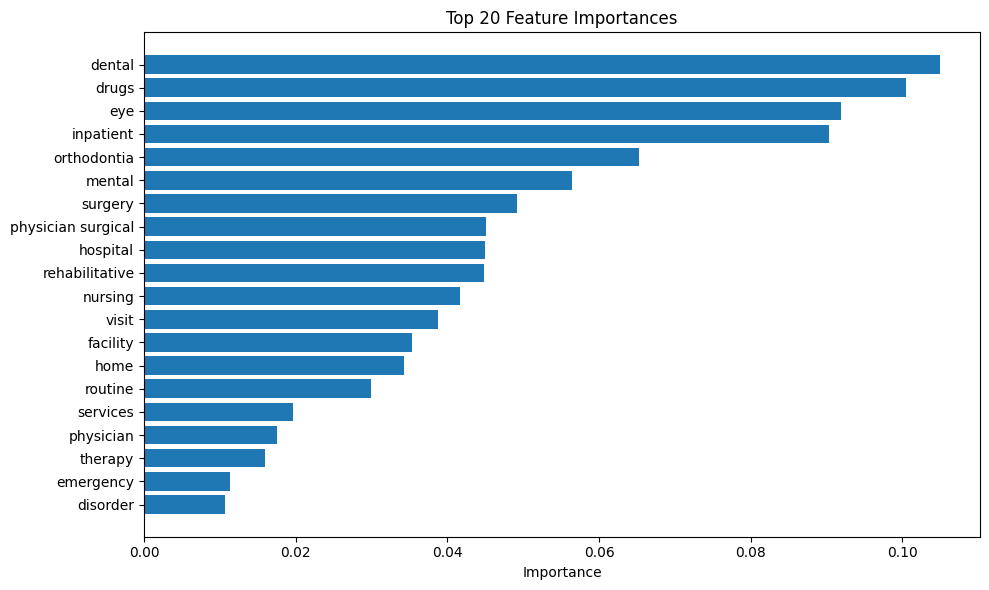

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Get feature names from TF-IDF vectorizer
vectorizer_features = vectorizer.get_feature_names_out()

# Combine with numeric feature names
all_feature_names = list(vectorizer_features) + numeric_features  # not X_train.columns

# Get feature importances
feature_importances = model.feature_importances_

# Create DataFrame for plotting
importance_df = pd.DataFrame({
    'Feature': all_feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Plot top N important features
top_n = 20
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'][:top_n][::-1], importance_df['Importance'][:top_n][::-1])
plt.xlabel('Importance')
plt.title(f'Top {top_n} Feature Importances')
plt.tight_layout()
plt.show()


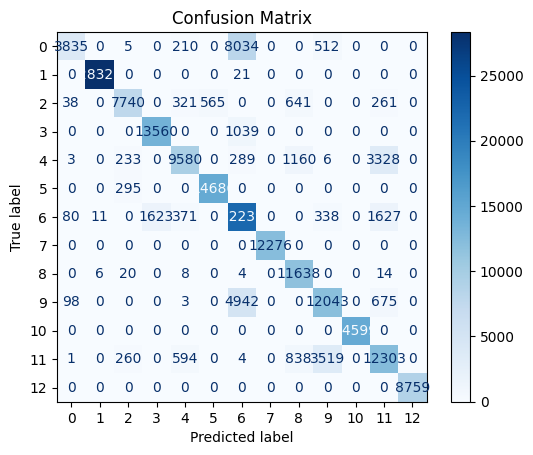

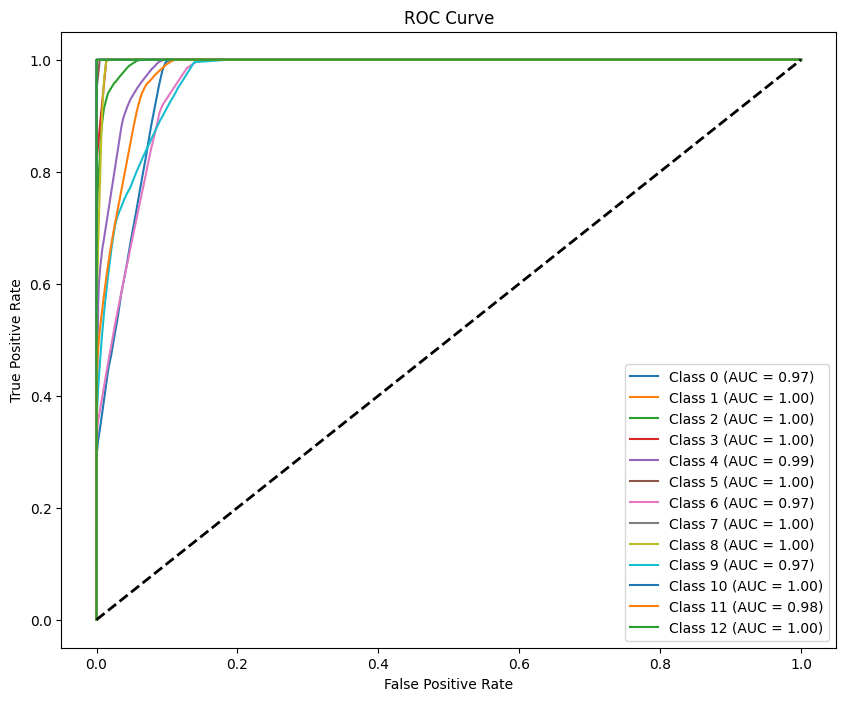

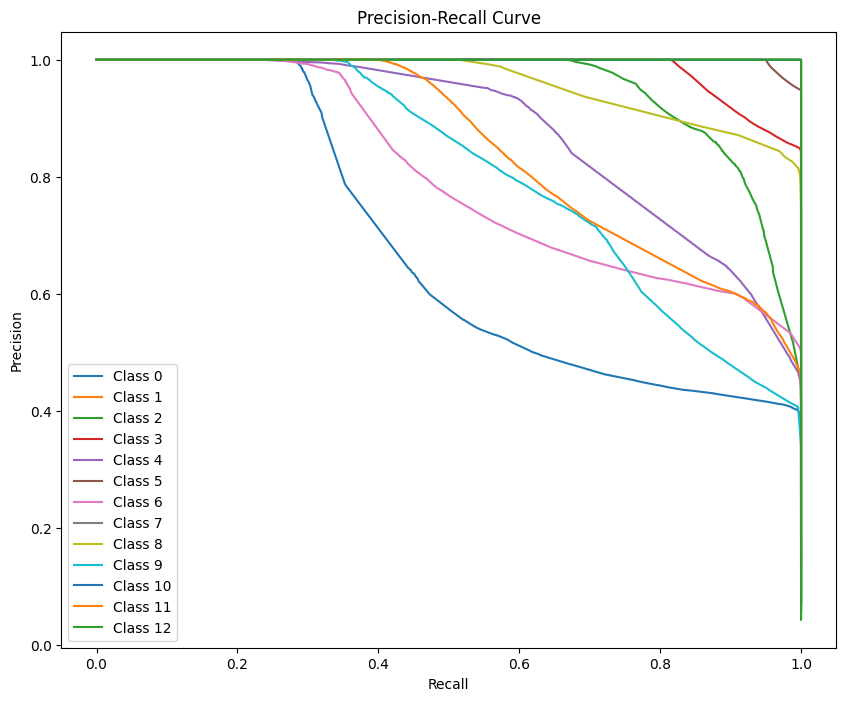

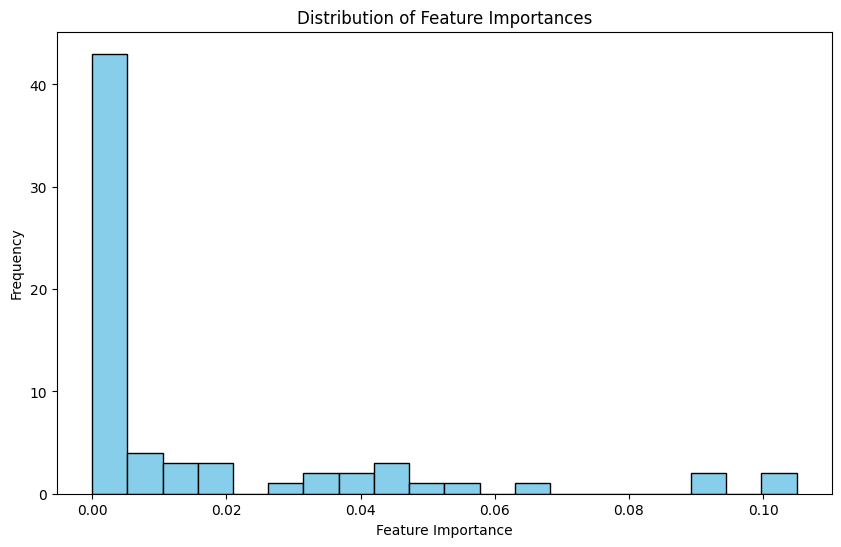

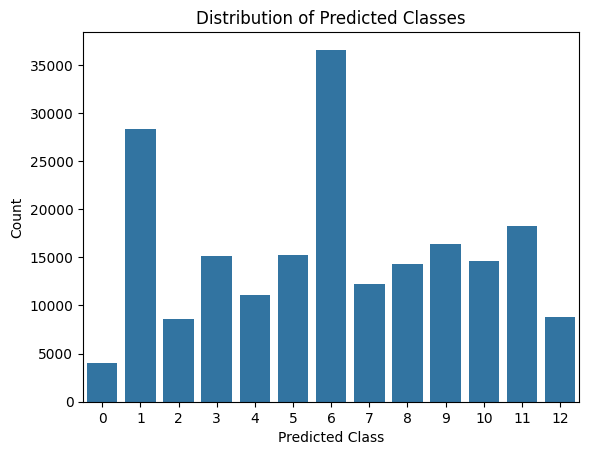

KeyboardInterrupt: 

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import precision_recall_curve
import seaborn as sns
from sklearn.model_selection import learning_curve

# Here are some additional graphs you can generate from the model and data:

# 1. **Confusion Matrix**:
#     Visualize the performance of the model by plotting a confusion matrix.
#     ```python

ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

# 2. **ROC Curve (for each class)**:
#     Plot the Receiver Operating Characteristic (ROC) curve for each class.
#     ```python

y_test_binarized = label_binarize(y_test, classes=np.unique(y))
y_pred_proba = model.predict_proba(X_test)

plt.figure(figsize=(10, 8))
for i in range(y_test_binarized.shape[1]):
        fpr, tpr, _ = roc_curve(y_test_binarized[:, i], y_pred_proba[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"Class {i} (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()

# 3. **Precision-Recall Curve**:
#     Plot the precision-recall curve for each class.
#     ```python

plt.figure(figsize=(10, 8))
for i in range(y_test_binarized.shape[1]):
        precision, recall, _ = precision_recall_curve(y_test_binarized[:, i], y_pred_proba[:, i])
        plt.plot(recall, precision, label=f"Class {i}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend(loc="lower left")
plt.show()

# 4. **Feature Importance Distribution**:
#     Plot the distribution of feature importances.
#     ```python
plt.figure(figsize=(10, 6))
plt.hist(feature_importances, bins=20, color='skyblue', edgecolor='black')
plt.xlabel("Feature Importance")
plt.ylabel("Frequency")
plt.title("Distribution of Feature Importances")
plt.show()


# 5. **Class Distribution in Predictions**:
#     Visualize the distribution of predicted classes.
#     ```python

sns.countplot(x=y_pred)
plt.xlabel("Predicted Class")
plt.ylabel("Count")
plt.title("Distribution of Predicted Classes")
plt.show()

# 6. **Learning Curve**:
#     Plot the learning curve to analyze the model's performance with varying training sizes.
#     ```python

train_sizes, train_scores, test_scores = learning_curve(
        model, X_combined, y, cv=5, scoring='accuracy', n_jobs=-1
)
train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, label="Training Score", marker='o')
plt.plot(train_sizes, test_mean, label="Validation Score", marker='o')
plt.xlabel("Training Size")
plt.ylabel("Accuracy")
plt.title("Learning Curve")
plt.legend()
plt.show()


# These visualizations can provide deeper insights into the model's performance and behavior.

C:\Users\nithi\AppData\Local\Temp\ipykernel_3712\902005500.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_pred, palette="viridis")


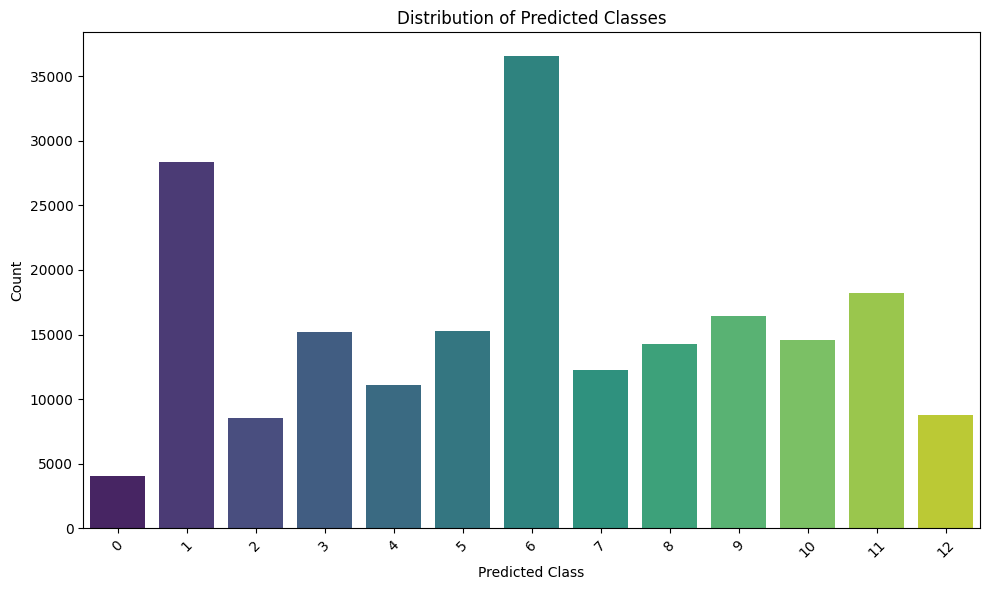

Insights:
Class 0: 4055 predictions (1.99%)
Class 1: 28345 predictions (13.92%)
Class 2: 8553 predictions (4.20%)
Class 3: 15183 predictions (7.46%)
Class 4: 11087 predictions (5.45%)
Class 5: 15251 predictions (7.49%)
Class 6: 36572 predictions (17.96%)
Class 7: 12276 predictions (6.03%)
Class 8: 14277 predictions (7.01%)
Class 9: 16418 predictions (8.06%)
Class 10: 14599 predictions (7.17%)
Class 11: 18208 predictions (8.94%)
Class 12: 8759 predictions (4.30%)

Classes with less than 5% of total predictions:
Class 0: 4055 predictions (1.99%)
Class 2: 8553 predictions (4.20%)
Class 12: 8759 predictions (4.30%)


In [19]:
# Plot the distribution of predicted classes
plt.figure(figsize=(10, 6))
sns.countplot(x=y_pred, palette="viridis")
plt.xlabel("Predicted Class")
plt.ylabel("Count")
plt.title("Distribution of Predicted Classes")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Insights
class_counts = pd.Series(y_pred).value_counts().sort_index()
total_predictions = len(y_pred)

print("Insights:")
for cls, count in class_counts.items():
    percentage = (count / total_predictions) * 100
    print(f"Class {cls}: {count} predictions ({percentage:.2f}%)")

# Highlight any imbalances
threshold = 5  # Percentage threshold to flag imbalances
imbalanced_classes = class_counts[class_counts / total_predictions * 100 < threshold]
if not imbalanced_classes.empty:
    print("\nClasses with less than 5% of total predictions:")
    for cls, count in imbalanced_classes.items():
        percentage = (count / total_predictions) * 100
        print(f"Class {cls}: {count} predictions ({percentage:.2f}%)")
else:
    print("\nNo significant class imbalance detected.")